In [243]:
import os
# Move working directory 1 level up
os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))
print("New working directory:", os.getcwd())

!pip install -r requirements.txt --quiet

New working directory: g:\


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [244]:
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Load environment variables from .env file, remember to create this file with your credentials
# Read readme file for more information ! 
load_dotenv("postgressql_secretkeys.env")  
# Extract variables
username = os.getenv("PG_USER")
password = os.getenv("PG_PASSWORD")
host     = os.getenv("PG_HOST")
port     = os.getenv("PG_PORT")
dbname   = os.getenv("PG_DB")

# Create the SQLAlchemy engine
engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{dbname}")

# Test connection
with engine.connect() as conn:
    result = conn.execute(text("SELECT version();"))
    print(result.fetchone())
    print("======================================= \n || -- Connected to PostgreSQL! -- || \n=======================================")


('PostgreSQL 17.4 on x86_64-windows, compiled by msvc-19.42.34436, 64-bit',)
 || -- Connected to PostgreSQL! -- || 


In [245]:
import pandas as pd
# Query a full table with all dimensions and fact from data warehouse query for data mining
query = """
SELECT * 
FROM fact_crash, dim_crash_group, dim_fatality_demographic, dim_time, dim_location
WHERE fact_crash.crashgroup_sk = dim_crash_group.crashgroup_sk
AND fact_crash.fatality_demographics_sk = dim_fatality_demographic.fatality_demographics_sk
AND fact_crash.time_sk = dim_time.time_sk
AND fact_crash.state_id = dim_location.state_id
"""
data = pd.read_sql(text(query), con=engine)
data.head(10)

,crash_sk,crash_id,crashgroup_sk,fatality_demographics_sk,time_sk,state_id,crashgroup_sk,crash_type,speed_limit,road_type,...,gender,age_group,time_sk,time,dayweek,month,year,state_id,state_name,population
0,1,20241115,1,1,1,NSW,1,Single,100,Arterial Road,...,Male,65_to_74,1,04,Friday,12,2024,NSW,New South Wales,8342285
1,2,20241125,2,2,2,NSW,2,Single,80,Local Road,...,Female,17_to_25,2,06,Friday,12,2024,NSW,New South Wales,8342285
2,3,20246013,3,3,3,TAS,3,Multiple,50,Local Road,...,Female,26_to_39,3,09,Friday,12,2024,TAS,Tasmania,573156
3,4,20241002,4,3,4,NSW,4,Multiple,100,National or State Highway,...,Female,26_to_39,4,10,Friday,12,2024,NSW,New South Wales,8342285
4,5,20242261,5,4,5,VIC,5,Multiple,Unknown,Undetermined,...,Male,40_to_64,5,11,Friday,12,2024,VIC,Victoria,6815441
5,6,20243185,4,5,6,QLD,4,Multiple,100,National or State Highway,...,Female,40_to_64,6,13,Friday,12,2024,QLD,Queensland,5460420
6,7,20244016,6,6,6,SA,6,Single,100,Sub-arterial Road,...,Male,40_to_64,6,13,Friday,12,2024,SA,South Australia,1852284
7,8,20245001,7,1,7,WA,7,Single,90,Undetermined,...,Male,65_to_74,7,17,Friday,12,2024,WA,Western Australia,2881227
8,9,20243168,8,7,8,QLD,8,Multiple,60,Local Road,...,Female,26_to_39,8,19,Friday,12,2024,QLD,Queensland,5460420
9,10,20246003,3,8,8,TAS,3,Multiple,50,Local Road,...,Male,17_to_25,8,19,Friday,12,2024,TAS,Tasmania,573156


In [246]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56874 entries, 0 to 56873
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   crash_sk                       56874 non-null  int64 
 1   crash_id                       56874 non-null  int64 
 2   crashgroup_sk                  56874 non-null  int64 
 3   fatality_demographics_sk       56874 non-null  int64 
 4   time_sk                        56874 non-null  int64 
 5   state_id                       56874 non-null  object
 6   crashgroup_sk                  56874 non-null  int64 
 7   crash_type                     56874 non-null  object
 8   speed_limit                    56874 non-null  object
 9   road_type                      56874 non-null  object
 10  bus_involvement                56874 non-null  object
 11  heavy_rigid_truck_involvement  56874 non-null  object
 12  articulated_truck_involvement  56874 non-null  object
 13  f

In [247]:
#Check missing values in the dataframe
data.isna()

#Count total missing values at each column in the dataframe
data.isna().sum()

crash_sk                          0
crash_id                          0
crashgroup_sk                     0
fatality_demographics_sk          0
time_sk                           0
state_id                          0
crashgroup_sk                     0
crash_type                        0
speed_limit                       0
road_type                         0
bus_involvement                   0
heavy_rigid_truck_involvement     0
articulated_truck_involvement     0
fatality_demographics_sk          0
road_user                         0
gender                            0
age_group                         0
time_sk                           0
time                             43
dayweek                           0
month                             0
year                              0
state_id                          0
state_name                        0
population                        0
dtype: int64

In [248]:
# Drop all the columns that are not needed for the analysis
data.drop(columns=['crashgroup_sk', 'fatality_demographics_sk', 'time_sk', 'state_id', "crash_sk", "crash_id"], inplace=True)
data_2=data.copy()

In [249]:
# Tranform the data to be used in the mining process using apriori algorithm
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

#Data transformation to str and then to list
#Convert all boolean values to column names and values Yes or No
data = data.astype(str)
data = data.apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1)

#TransactionEncoder() was designed to covert lists to array
list_ = data.values.tolist()

#Covert the list to one-hot encoded boolean numpy array. 
#Apriori function allows boolean data type only, such as 1 and 0, or FALSE and TRUE.
te = TransactionEncoder()
array_te = te.fit(list_).transform(list_)

#Check the array
array_te

#Check the colunms
te.columns_

#Apriori function can handle dataframe only, covert the array to a dataframe
arm_df = pd.DataFrame(array_te, columns = te.columns_)
arm_df

,age_group=0_to_16,age_group=17_to_25,age_group=26_to_39,age_group=40_to_64,age_group=65_to_74,age_group=75_or_older,age_group=Unknown,articulated_truck_involvement=No,articulated_truck_involvement=Unknown,articulated_truck_involvement=Yes,...,year=2015,year=2016,year=2017,year=2018,year=2019,year=2020,year=2021,year=2022,year=2023,year=2024
0,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56869,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
56870,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
56871,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
56872,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [250]:
frequent_itemsets = apriori(arm_df,min_support=0.2,use_colnames =True, )
frequent_itemsets

,support,itemsets
0,0.255688,(age_group=17_to_25)
1,0.232778,(age_group=26_to_39)
2,0.257446,(age_group=40_to_64)
3,0.899356,(articulated_truck_involvement=No)
4,0.980501,(bus_involvement=No)
...,...,...
212,0.233481,"(bus_involvement=No, road_type=Undetermined, c..."
213,0.272532,"(gender=Male, bus_involvement=No, road_type=Un..."
214,0.221947,"(gender=Male, bus_involvement=No, road_type=Un..."
215,0.228681,"(road_user=Driver, gender=Male, bus_involvemen..."


In [251]:
#Find the frequent itemsets
frequent_itemsets = apriori(arm_df,min_support=0.05,use_colnames =True)

#Check the length of rules
frequent_itemsets['length']=frequent_itemsets['itemsets'].apply(lambda x: len(x))

# We use length to filter the rules, we want to find the rules with length >= 2 so it wont be only one item in the rule
# We also filter the rules with support >= 0.3, so we can find the most frequent itemsets

length = 2 # Min Length of the patterns we want to find
support = 0.3 # Min Support of the patterns we want to find
frequent_itemsets[ (frequent_itemsets['length']>=1) & 
                  (frequent_itemsets['support']>=0.1)]

,support,itemsets,length
1,0.255688,(age_group=17_to_25),1
2,0.232778,(age_group=26_to_39),1
3,0.257446,(age_group=40_to_64),1
6,0.899356,(articulated_truck_involvement=No),1
8,0.980501,(bus_involvement=No),1
...,...,...,...
3872,0.125101,"(population=8342285, bus_involvement=No, state...",6
3910,0.110507,"(gender=Male, road_type=Undetermined, state_na...",6
3962,0.121479,"(gender=Male, bus_involvement=No, road_type=Un...",6
3971,0.100204,"(population=8342285, bus_involvement=No, gende...",6


In [252]:
#Assume the min confidence is 0.5
rules_con = association_rules(frequent_itemsets, metric="confidence",min_threshold=0.5)
rules_con[["antecedents","consequents", "antecedent support", "consequent support", "support", "confidence", "lift"]]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(age_group=0_to_16),(articulated_truck_involvement=No),0.075236,0.899356,0.069434,0.922879,1.026155
1,(age_group=0_to_16),(bus_involvement=No),0.075236,0.980501,0.073566,0.977799,0.997244
2,(age_group=0_to_16),(road_type=Undetermined),0.075236,0.811197,0.065900,0.875906,1.079770
3,(age_group=17_to_25),(articulated_truck_involvement=No),0.255688,0.899356,0.236136,0.923532,1.026881
4,(age_group=17_to_25),(bus_involvement=No),0.255688,0.980501,0.252066,0.985834,1.005439
...,...,...,...,...,...,...,...
24463,"(road_user=Driver, population=6815441, state_n...","(gender=Male, bus_involvement=No, road_type=Un...",0.100186,0.272532,0.050744,0.506494,1.858472
24464,"(road_user=Driver, population=6815441, articul...","(gender=Male, bus_involvement=No, road_type=Un...",0.087281,0.121479,0.050744,0.581386,4.785895
24465,"(road_user=Driver, population=6815441, heavy_r...","(gender=Male, bus_involvement=No, road_type=Un...",0.095949,0.112477,0.050744,0.528862,4.701969
24466,"(road_user=Driver, state_name=Victoria)","(gender=Male, bus_involvement=No, road_type=Un...",0.100186,0.109171,0.050744,0.506494,4.639445


In [253]:
#Assume the min lift is 1
rules_lift = association_rules(frequent_itemsets, metric="lift",min_threshold=1)

#output antecedents, consequents, support, confidence and lift.
result_arm = rules_con[['antecedents','consequents','support','confidence','lift']]
result_arm

,antecedents,consequents,support,confidence,lift
0,(age_group=0_to_16),(articulated_truck_involvement=No),0.069434,0.922879,1.026155
1,(age_group=0_to_16),(bus_involvement=No),0.073566,0.977799,0.997244
2,(age_group=0_to_16),(road_type=Undetermined),0.065900,0.875906,1.079770
3,(age_group=17_to_25),(articulated_truck_involvement=No),0.236136,0.923532,1.026881
4,(age_group=17_to_25),(bus_involvement=No),0.252066,0.985834,1.005439
...,...,...,...,...,...
24463,"(road_user=Driver, population=6815441, state_n...","(gender=Male, bus_involvement=No, road_type=Un...",0.050744,0.506494,1.858472
24464,"(road_user=Driver, population=6815441, articul...","(gender=Male, bus_involvement=No, road_type=Un...",0.050744,0.581386,4.785895
24465,"(road_user=Driver, population=6815441, heavy_r...","(gender=Male, bus_involvement=No, road_type=Un...",0.050744,0.528862,4.701969
24466,"(road_user=Driver, state_name=Victoria)","(gender=Male, bus_involvement=No, road_type=Un...",0.050744,0.506494,4.639445


In [254]:
#Find the rules whose confidence >= 0.7
new_result_arm = result_arm[result_arm['confidence']>=0.5]
new_result_arm

,antecedents,consequents,support,confidence,lift
0,(age_group=0_to_16),(articulated_truck_involvement=No),0.069434,0.922879,1.026155
1,(age_group=0_to_16),(bus_involvement=No),0.073566,0.977799,0.997244
2,(age_group=0_to_16),(road_type=Undetermined),0.065900,0.875906,1.079770
3,(age_group=17_to_25),(articulated_truck_involvement=No),0.236136,0.923532,1.026881
4,(age_group=17_to_25),(bus_involvement=No),0.252066,0.985834,1.005439
...,...,...,...,...,...
24463,"(road_user=Driver, population=6815441, state_n...","(gender=Male, bus_involvement=No, road_type=Un...",0.050744,0.506494,1.858472
24464,"(road_user=Driver, population=6815441, articul...","(gender=Male, bus_involvement=No, road_type=Un...",0.050744,0.581386,4.785895
24465,"(road_user=Driver, population=6815441, heavy_r...","(gender=Male, bus_involvement=No, road_type=Un...",0.050744,0.528862,4.701969
24466,"(road_user=Driver, state_name=Victoria)","(gender=Male, bus_involvement=No, road_type=Un...",0.050744,0.506494,4.639445


In [255]:
# Filter the new_result_arm by containing "road_user"
# Chỉ lấy những rule có chứa "road_user" trong phần consequents
filtered_rules = new_result_arm[
    new_result_arm['consequents'].astype(str).str.contains('road_user=', case=False)
]

filtered_rules

,antecedents,consequents,support,confidence,lift
15,(age_group=26_to_39),(road_user=Driver),0.117330,0.504041,1.116266
22,(age_group=40_to_64),(road_user=Driver),0.131607,0.511201,1.132122
93,(articulated_truck_involvement=Yes),(road_user=Driver),0.062190,0.624691,1.383461
310,(speed_limit=100),(road_user=Driver),0.195203,0.570064,1.262483
311,(speed_limit=110),(road_user=Driver),0.063597,0.554925,1.228955
...,...,...,...,...,...
22950,"(gender=Male, bus_involvement=No, road_type=Un...","(road_user=Driver, articulated_truck_involveme...",0.058761,0.539990,1.388526
22951,"(gender=Male, road_type=Undetermined, crash_ty...","(road_user=Driver, bus_involvement=No)",0.058761,0.579203,1.298344
22956,"(road_type=Undetermined, gender=Male, crash_ty...","(road_user=Driver, bus_involvement=No, articul...",0.058761,0.537472,1.398425
23332,"(gender=Male, bus_involvement=No, road_type=Un...",(road_user=Driver),0.055104,0.577589,1.279149


THERE IS A COOL THING IN THIS !!

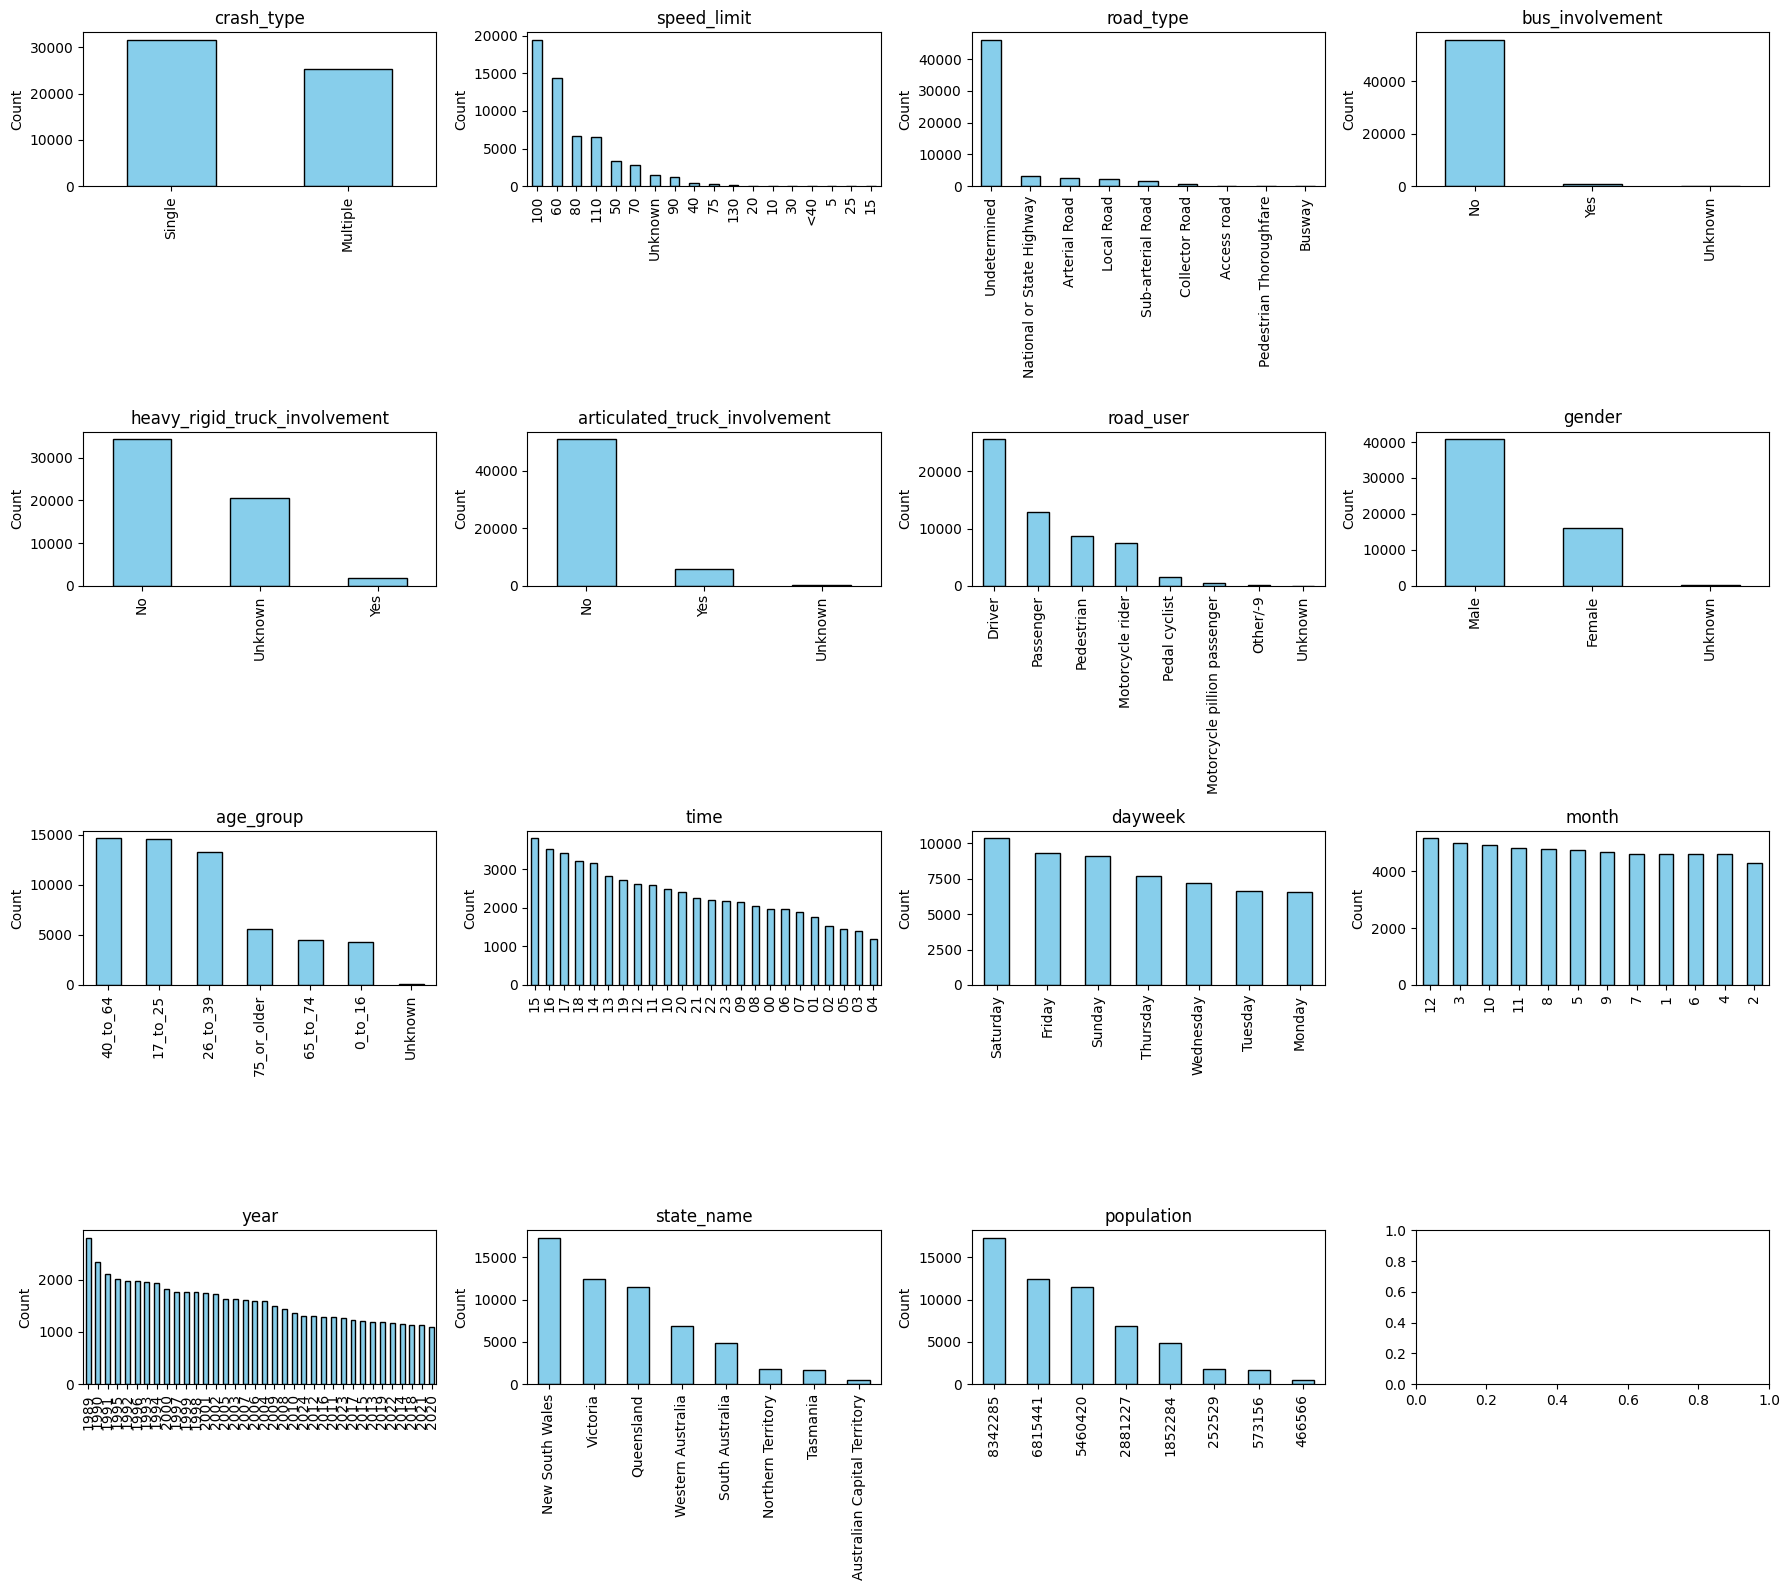

In [256]:
# Plots for exploratory data analysis
import matplotlib.pyplot as plt

n_cols = 4
n_rows = 4  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(data_2.columns):
    ax = axes[i]
    if data_2[col].dtype == 'object' or data_2[col].nunique() < 15:
        data_2[col].value_counts().plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
        ax.set_ylabel('Count')
    else:
        data_2[col].dropna().plot(kind='hist', ax=ax, bins=20, edgecolor='black')
        ax.set_ylabel('Frequency')
    ax.set_title(col)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()
